**Table of contents**<a id='toc0_'></a>    
- 1. [Pre-processing          ](#toc1_)    
- 2. [Load data          ](#toc2_)    
  - 2.1. [Load earthquake catalog          ](#toc2_1_)    
  - 2.2. [Load original tremor and model depth        ](#toc2_2_)    
  - 2.3. [Map it       ](#toc2_3_)    
- 3. [Project along-strike ](#toc3_)    
- 4. [Trim catalogs     ](#toc4_)    
- 5. [Count number of earthquakes that can trigger tremor        ](#toc5_)    
  - 5.1. [Ball tree (approximate but fast)](#toc5_1_)    
  - 5.2. [Brute force / NN distance](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Pre-processing           [&#128285;](#toc0_)

- Projecting tremor on slab
- Trimming tremor to exclude shallow patches
- Counting earthquakes that can trigger tremor

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'

In [2]:
# Geographic distance
def distance(lon1, lat1, z1, lon2, lat2, z2):
    # Convert degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Compute differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance_km = 6371 * c

    distance_km = np.sqrt(distance_km**2 + (z2 - z1)**2)

    return distance_km

# 2. <a id='toc2_'></a>Load data           [&#128285;](#toc0_)

In [3]:
# Constants
day0 = np.datetime64('2009-08-01')
minlat = 39
maxlat = 52
minlon = -128
maxlon = -121

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog           [&#128285;](#toc0_)

Could improve:
- Merge with CNSN catalog

In [4]:
# Load earthquakes
path = workdir + "projects/data/Catalogs/cascadia_eq_anss_0924/cascadia_eq_anss_0924.csv"
eq = pd.read_csv(path, parse_dates=['time'])

# Rename columns
eq.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'time': 'date'}, inplace=True)

# Sort by date
eq.sort_values('date', inplace=True)

# Keep only data that we are using
eq.drop(['magType', 'nst', 'dmin', 'rms', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource', 'net', 'gap', 'id'], axis=1, inplace=True)

## 2.2. <a id='toc2_2_'></a>Load original tremor and model depth         [&#128285;](#toc0_)

In [5]:
# Load original tremor catalog
path = workdir + "projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0624.csv"
trm = pd.read_csv(path, parse_dates=['starttime'], low_memory=False)

# Rename columns
trm.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'starttime': 'date'}, inplace=True)

# Sort by date
trm.sort_values('date', inplace=True)

# Remove columns energy and duration
trm.drop(columns=['energy'], inplace=True)
trm.drop(columns=['duration '], inplace=True)

In [6]:
# Load slab
path = workdir + "projects/data/Slabs/cascadia_slab_bostock19/cascadia_slab_bostock19.csv"
slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], sep=' ')

In [7]:
# Project tremor onto slab: find nearest neighbor
# --> Convert to cartesian coordinates
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(crs, trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(crs, eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(crs, slab.lon.values, slab.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000

# --> Find nearest neighbor
from scipy.spatial import cKDTree
tree = cKDTree(slab[['x', 'y']].values)
dist, idx = tree.query(trm[['x', 'y']].values)
trm['depth'] = slab.loc[idx, 'depth'].values

## 2.3. <a id='toc2_3_'></a>Map it        [&#128285;](#toc0_)

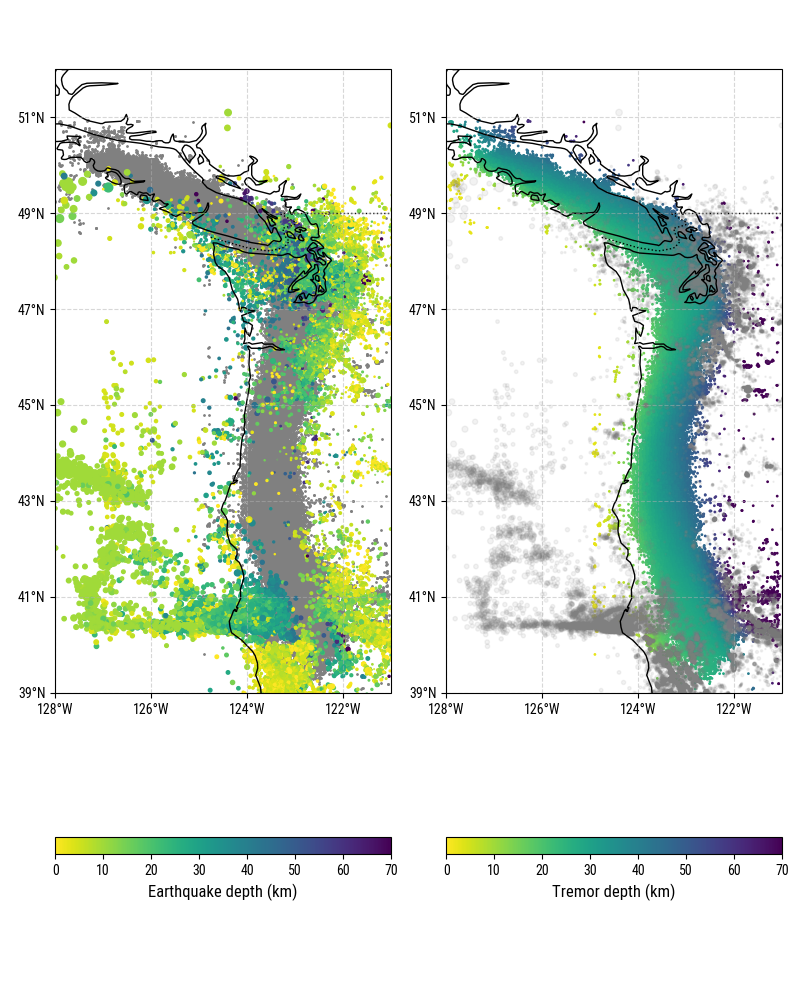

In [8]:
# Plot it
fig = plt.figure(figsize=(8, 10))
axes = [fig.add_subplot(121, projection=ccrs.PlateCarree()), fig.add_subplot(122, projection=ccrs.PlateCarree())]

for ax in axes:
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(minlon, maxlon, 2))
    ax.set_yticks(np.arange(minlat, maxlat, 2))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)


# Plot earthquakes and tremor
sc = axes[0].scatter(eq.lon, eq.lat, s=eq.mag**2, c=eq.depth, cmap='viridis_r', transform=ccrs.PlateCarree(), vmin=0, vmax=70)
axes[0].scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree(), zorder=-1)
cbar = plt.colorbar(sc, ax=axes[0], orientation='horizontal', label='Earthquake depth (km)')

axes[1].scatter(eq.lon, eq.lat, s=eq.mag**2, c=[to_rgba('.5', .1) for ii in range(len(eq))],transform=ccrs.PlateCarree())
sc = axes[1].scatter(trm.lon, trm.lat, s=1, c=trm.depth, transform=ccrs.PlateCarree(), zorder=-1, cmap='viridis_r', vmin=0, vmax=70)
cbar = plt.colorbar(sc, ax=axes[1], orientation='horizontal', label='Tremor depth (km)')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Project along-strike  [&#128285;](#toc0_)

In [9]:
# Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

In [10]:
# Define along-strike: fit a polynomial to the tremor line
# We will have work with y (longitudinal coordinate) as a function of x
p_strike = np.polyfit(trm.y, trm.x, 4)

# # Show
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_aspect('equal')
# ax.set_xlabel('y (km)')
# ax.set_ylabel('x (km)')

# ax.scatter(trm.y, trm.x, s=1, c='k')

# y = np.arange(-700, 700, 1)
# x = np.polyval(p_strike, y)
# ax.plot(y, x, 'r', zorder=10)

# plt.tight_layout()
# plt.show()

In [11]:
# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
y0, x0 = -700, np.polyval(p_strike, -700)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
y = y0
while y < 700:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dy = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), y))**2)
    y += dy
    x = np.polyval(p_strike, y)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((Y, X)))
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.y, eq.x)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.y, trm.x)))

eq_along_strike_dist = S[eq_nearest_idx]
trm_along_strike_dist = S[trm_nearest_idx]

eq['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km
trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('y (km)')  
#     ax.set_ylabel('x (km)')
#     ax.plot(Y, X, 'r', zorder=10)

# axes[0].scatter(eq.y, eq.x, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(trm.y, trm.x, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=1500)

# axes[1].scatter(eq.y, eq.x, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(trm.y, trm.x, s=1, c=trm_across_strike_dist, cmap='viridis')

# plt.tight_layout()
# plt.show()

# 4. <a id='toc4_'></a>Trim catalogs      [&#128285;](#toc0_)

In [12]:
# Using the depths
min_depth = 10
max_depth = 60

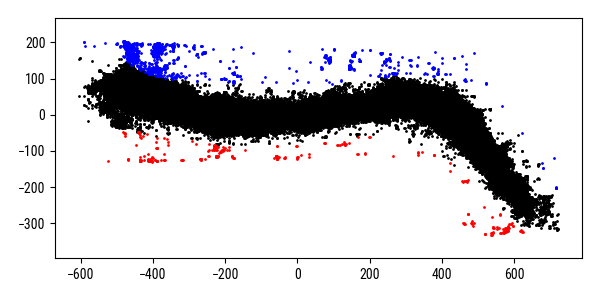

In [13]:
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('equal')
ax.scatter(trm.y[(trm.depth > min_depth) & (trm.depth < max_depth)], trm.x[(trm.depth > min_depth) & (trm.depth < max_depth)], s=1, c='k')
ax.scatter(trm.loc[(trm.depth < min_depth), 'y'], trm.loc[(trm.depth < min_depth), 'x'], s=1, c='r')
ax.scatter(trm.loc[(trm.depth > max_depth), 'y'], trm.loc[(trm.depth > max_depth), 'x'], s=1, c='b')
plt.tight_layout()
plt.show()

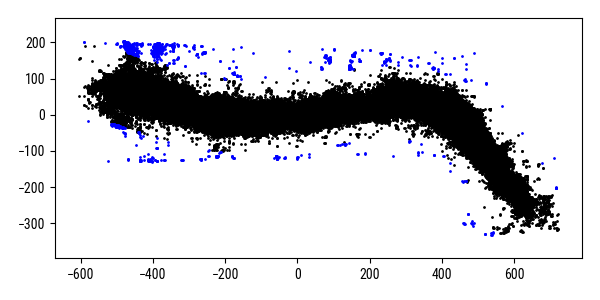

In [14]:
# Using across_strike distance
max_dist = 100
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('equal')
ax.scatter(trm.y[(trm.yf < max_dist)], trm.x[(trm.yf < max_dist)], s=1, c='k')
ax.scatter(trm.loc[(trm.yf > max_dist), 'y'], trm.loc[(trm.yf > max_dist), 'x'], s=1, c='b')
plt.tight_layout()
plt.show()

In [15]:
# If ok, trim tremor and save it
trm = trm[(trm.yf < max_dist)]
# trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_trim.csv', columns=['date', 'lat', 'lon', 'depth'], index=False)

# 5. <a id='toc5_'></a>Count number of earthquakes that can trigger tremor         [&#128285;](#toc0_)

In [16]:
epicentral = False

In [30]:
# Which earthquakes should count
interval = [np.datetime64('2009-09-01'), np.datetime64('2024-06-01')]
min_mag = 2.  # Mc~1.5
selected_eq = eq[(eq.date.values >= interval[0]) & (eq.date.values <= interval[1]) & (eq.mag >= min_mag)].copy()
print(f"Selected {len(selected_eq)} earthquakes")

Selected 14920 earthquakes


## 5.1. <a id='toc5_1_'></a>Ball tree (approximate but fast) [&#128285;](#toc0_)

In [31]:
# Compute the number of earthquakes at a close distance for each tremor (~2m40s)
from scipy.spatial import cKDTree

dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(trm)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    trm_tree = cKDTree(trm[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = trm_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

# Convert counts to rates per year
n_eq = n_eq / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

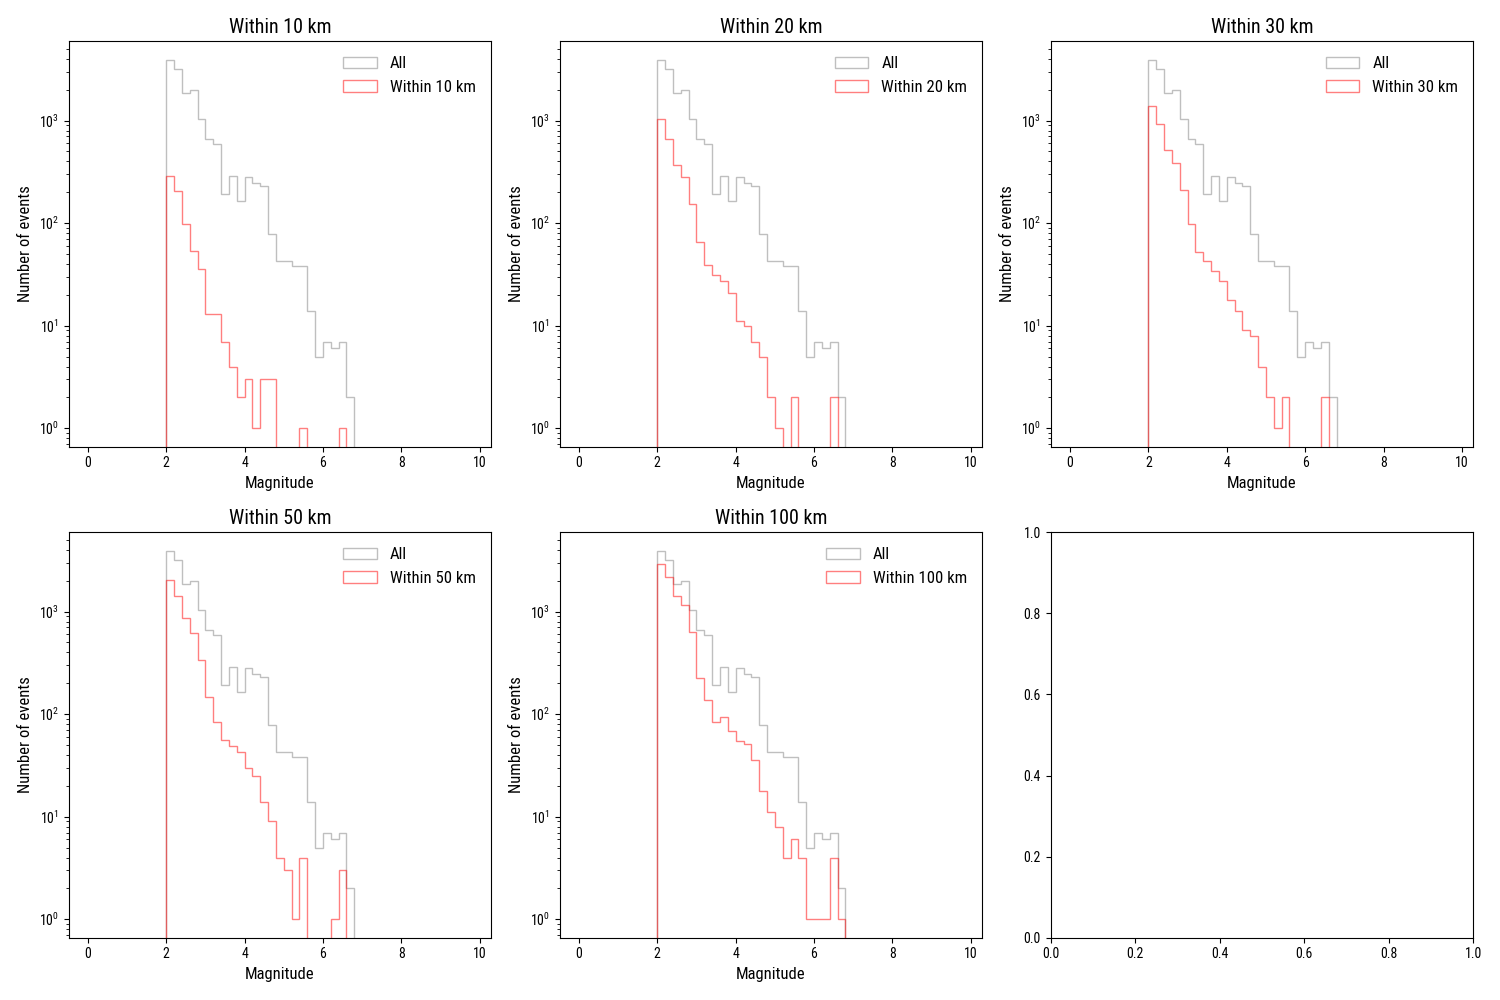

In [33]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag.values, bins=np.arange(0, 10, .2), color='gray', alpha=.5, label='All', histtype='step', zorder=0)
    ax.hist(selected_eq.mag.values[eq_at_dist[jj]], bins=np.arange(0, 10, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), histtype='step', zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

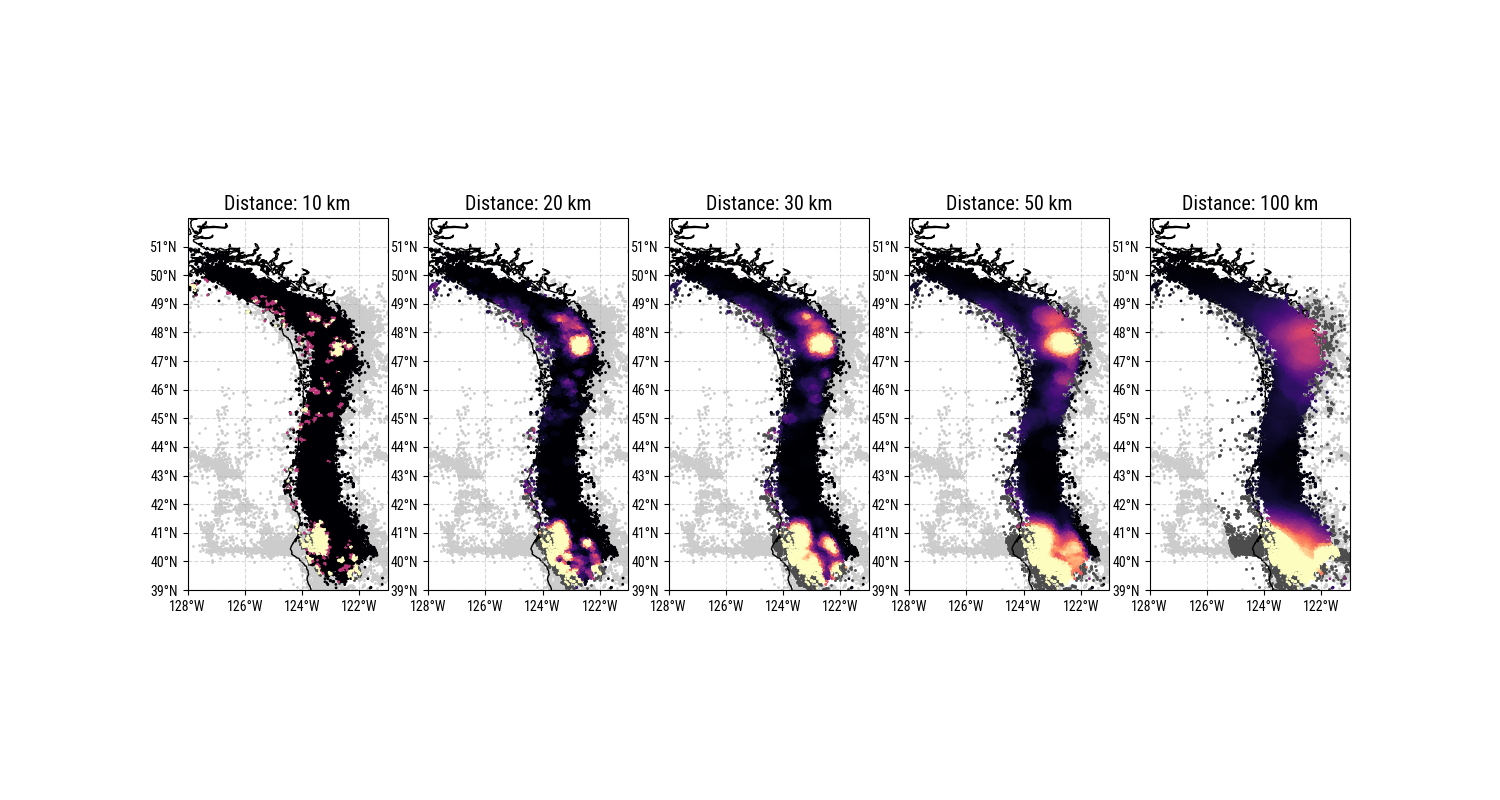

In [34]:
# Plot it
lon_min = minlon
lon_max = maxlon
lat_min = minlat
lat_max = maxlat
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 8))
axes = [plt.subplot(1, 5, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(dists)), axes):
    ax.set_title('Distance: {:d} km'.format(dists[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=n_eq[ii, :], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eq[ii, :], 95), zorder=2, label='Tremor')
    ax.scatter(selected_eq.lon[eq_at_dist[ii]], selected_eq.lat[eq_at_dist[ii]], c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(dists[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    #ax.legend(loc='lower left', fontsize='small', framealpha=.5, scatterpoints=10, markerscale=3)

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]))

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
plt.show()

In [35]:
# Save it
trm.loc[:, 'n_eq_10km'] = n_eq[0, :]
trm.loc[:, 'n_eq_20km'] = n_eq[1, :]
trm.loc[:, 'n_eq_30km'] = n_eq[2, :]
trm.loc[:, 'n_eq_50km'] = n_eq[3, :]
trm.loc[:, 'n_eq_100km'] = n_eq[4, :]

trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_trim_eqdist_mc{:.1f}.csv'.format(min_mag), index=False)

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/cascadia/processed/casc_eqmc{:.1f}_0809_0624_trim_eqdist.csv'.format(min_mag), index=False)

## 5.2. <a id='toc5_2_'></a>Brute force / NN distance [&#128285;](#toc0_)

In [32]:
# compute=False

In [33]:
# # Compute number of earthquakes at stressing distance for each tremor
# if compute:
#     n_5km = np.zeros(trm.shape[0])
#     n_10km = np.zeros(trm.shape[0])
#     n_20km = np.zeros(trm.shape[0])
#     n_30km = np.zeros(trm.shape[0])

#     eq_5km = np.zeros(selected_eq.shape[0], dtype=bool)
#     eq_10km = np.zeros(selected_eq.shape[0], dtype=bool)
#     eq_20km = np.zeros(selected_eq.shape[0], dtype=bool)
#     eq_30km = np.zeros(selected_eq.shape[0], dtype=bool)

#     subset_size = 100  # Number of tremors to process at once
#     ii = 0
#     while ii < trm.shape[0]:
#         print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
#         # Subset
#         lons = trm.lon.values[ii:ii+subset_size]
#         lats = trm.lat.values[ii:ii+subset_size]
#         depths = trm.depth.values[ii:ii+subset_size]

#         # Compute distances (dim (subset_size, n_eq))
#         distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], depths[:, np.newaxis], selected_eq.lat.values, selected_eq.lon.values, selected_eq.depth.values)
#         dist5 = distances < 5.
#         dist10 = distances < 10.
#         dist20 = distances < 20.
#         dist30 = distances < 30.

#         # Count number of earthqakes (dim (subset_size, ))
#         n_5km[ii:ii+subset_size] = dist5.sum(axis=1)
#         n_10km[ii:ii+subset_size] = dist10.sum(axis=1)
#         n_20km[ii:ii+subset_size] = dist20.sum(axis=1)
#         n_30km[ii:ii+subset_size] = dist30.sum(axis=1)

#         # Select earthquakes
#         eq_5km = dist5.any(axis=0) | eq_5km
#         eq_10km = dist10.any(axis=0) | eq_10km
#         eq_20km = dist20.any(axis=0) | eq_20km
#         eq_30km = dist30.any(axis=0) | eq_30km

#         # Update ii
#         ii = ii + subset_size

In [34]:
# # Save it?
# save=Falses

In [35]:
# # Save it
# if save:
#     trm['n_eq_5km'] = n_5km
#     trm['n_eq_10km'] = n_10km
#     trm['n_eq_20km'] = n_20km
#     trm['n_eq_30km'] = n_30km

#     trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_trim_eqdist.csv', index=False)

    
#     selected_eq['eq_5km'] = eq_5km
#     selected_eq['eq_10km'] = eq_10km
#     selected_eq['eq_20km'] = eq_20km
#     selected_eq['eq_30km'] = eq_30km

#     selected_eq.to_csv('data/cascadia/processed/casc_eq_0809_0624_eqdist.csv', index=False)s

In [36]:
# # Show it
# fig = plt.figure(figsize=(12, 8))
# crs = ccrs.PlateCarree()
# axes = [plt.subplot(1, 4, ii+1, projection=crs) for ii in range(4)]
# n_eqs = [n_5km, n_10km, n_20km, n_30km]
# dists_str = ['5', '10', '20', '30']

# for ii, ax in zip(range(4), axes):
#     # Plot tremor
#     sc = ax.scatter(trm.lon, trm.lat, c=n_eqs[ii], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eqs[ii], 95))
#     cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='#EQ closer than {:d} km'.format(dists[ii]))

#     ax.set_extent([minlon, maxlon, minlat, maxlat], crs=crs)
#     ax.coastlines(lw=1)

#     # grid and labels, only bottom and left, not top and right
#     ax.set_xticks(np.arange(minlon, maxlon, 2), crs=crs)
#     ax.set_yticks(np.arange(minlat, maxlat, 2), crs=crs)
#     ax.xaxis.set_major_formatter(LongitudeFormatter())
#     ax.yaxis.set_major_formatter(LatitudeFormatter())
#     ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
# plt.show()